## Introduction to Applying Large Language Models to Spatial Data

### Import the required Python Libraries

In [3]:
from openai import OpenAI
import pandas as pd
import os
import json
import re
import time
import random
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
import numpy as np

### LLM Client Setup 

In [4]:
client = OpenAI(base_url="http://localhost:1234/v1", api_key="lm-studio")
model_name = "google/gemma-3-4b"

# Configure whether to use the OpenAI API (True) or an offline keyword classifier (False)
USE_OPENAI = False

### Load the dataset

In [7]:
INPUT_FILE = "/Users/devikakakkar/Downloads/tweets_US_English_1000.csv"   ##Change the file path to your path
df = pd.read_csv(INPUT_FILE, dtype=str)

### Clean the dataset

In [8]:
def clean_text(text: str) -> str:
    text = re.sub(r"http\S+", "", text)        # URLs
    text = re.sub(r"@\w+", "", text)           # @mentions
    text = re.sub(r"#", "", text)               # remove hashtag symbol
    text = re.sub(r"\s+", " ", text)           # whitespace
    return text.strip()

df["clean_text"] = df["text"].apply(clean_text)
df[["tweetid","city","text","clean_text"]].head(10)

,tweetid,city,text,clean_text
0,1,"Washington, DC",Digital twin pilot launched for flood manageme...,Digital twin pilot launched for flood manageme...
1,2,"Charlotte, NC",IoT sensors deployed to monitor water leaks in...,IoT sensors deployed to monitor water leaks in...
2,3,"Washington, DC","New community clinic opens in Washington, DC w...","New community clinic opens in Washington, DC w..."
3,4,"San Diego, CA","Teachers in San Diego, CA receive innovation g...","Teachers in San Diego, CA receive innovation g..."
4,5,"Columbus, OH",Electric buses roll out on city routes in Colu...,Electric buses roll out on city routes in Colu...
5,6,"Phoenix, AZ",Recycling rates rise 452% after new policy rol...,Recycling rates rise 452% after new policy rol...
6,7,"Denver, CO","Clean air campaign gains traction in Denver, C...","Clean air campaign gains traction in Denver, C..."
7,8,"Dallas, TX",Mental health awareness walk happening downtow...,Mental health awareness walk happening downtow...
8,9,"Boston, MA","Neighborhood cleanup day in Boston, MA collect...","Neighborhood cleanup day in Boston, MA collect..."
9,10,"Columbus, OH","Coding bootcamp enrollment surges in Columbus,...","Coding bootcamp enrollment surges in Columbus,..."


### Explore the dataset

In [9]:
num_records, num_attributes = df.shape
print(f'Number of records: {num_records}')
print(f'Number of attributes (columns): {num_attributes}')

# -----------------------------------------------------------------------------
# Inspect the first few entries to verify content and schema
# -----------------------------------------------------------------------------
display(df.head(3))
# -----------------------------------------------------------------------------
# Count unique identifiers and scientific names
# -----------------------------------------------------------------------------
# Use GeoDataFrame methods for efficiency instead of converting to a Python set.
unique_id_count = df['tweetid'].nunique()
unique_name_count = df['username'].nunique()

# -----------------------------------------------------------------------------
# Output results with clear labeling
# -----------------------------------------------------------------------------
print(f'Unique tweet ids: {unique_id_count}')
print(f'Unique username names: {unique_name_count}')

Number of records: 996
Number of attributes (columns): 7


,tweetid,username,text,lat,lon,city,clean_text
0,1,@OpenDataLab,Digital twin pilot launched for flood manageme...,38.920095,-77.033555,"Washington, DC",Digital twin pilot launched for flood manageme...
1,2,@CityObserver,IoT sensors deployed to monitor water leaks in...,35.238777,-80.860648,"Charlotte, NC",IoT sensors deployed to monitor water leaks in...
2,3,@WaterWatchUSA,"New community clinic opens in Washington, DC w...",38.915161,-77.049643,"Washington, DC","New community clinic opens in Washington, DC w..."


Unique tweet ids: 996
Unique username names: 24


### Analyse the spatial distribution

Top 10 Cities by Tweet Count:
city
San Jose, CA        63
Austin, TX          61
Miami, FL           59
Los Angeles, CA     55
Dallas, TX          55
Phoenix, AZ         54
San Antonio, TX     51
Philadelphia, PA    51
Jacksonville, FL    50
Columbus, OH        50
Name: count, dtype: int64


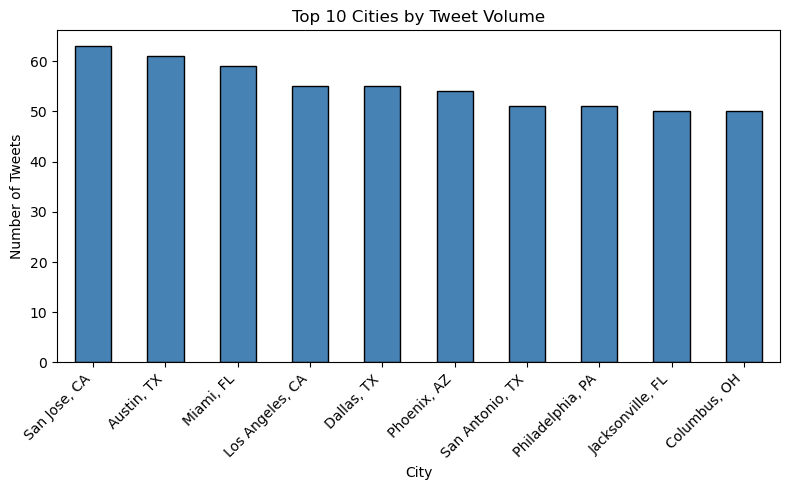

In [10]:

# --- Check that 'city' column exists ---
if "city" not in df.columns:
    raise KeyError("The dataset does not contain a 'city' column.")

# --- Compute top 10 cities by tweet count ---
top_cities = df["city"].value_counts().head(10)
print("Top 10 Cities by Tweet Count:")
print(top_cities)

# --- Plot the bar chart ---
plt.figure(figsize=(8, 5))
top_cities.plot(
    kind="bar",
    color="steelblue",
    edgecolor="black"
)
plt.title("Top 10 Cities by Tweet Volume")
plt.xlabel("City")
plt.ylabel("Number of Tweets")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Analyse the spatial distribution on map

In [11]:
# --- Basic validation ---
required = {"lat", "lon"}
missing = required - set(df.columns)
if missing:
    raise KeyError(f"CSV missing required columns: {missing}")

# Remove rows with missing/invalid coords
df = df.dropna(subset=["lat", "lon"])

# --- Create base map (centered on continental US by default) ---
m = folium.Map(location=[39.5, -98.35], zoom_start=4, tiles="CartoDB positron")

# Cluster markers for performance
cluster = MarkerCluster().add_to(m)

# --- Add raw tweet points ---
for _, r in df.iterrows():
    popup_html = (
        f"<b>City:</b> {r.get('city', 'N/A')}<br>"
        f"<b>Tweet:</b> {str(r.get('text', ''))[:240]}..."
    )
    folium.CircleMarker(
        location=[float(r["lat"]), float(r["lon"])],
        radius=4,
        color="cadetblue",
        fill=True,
        fill_color="cadetblue",
        fill_opacity=0.7,
        popup=folium.Popup(popup_html, max_width=320)
    ).add_to(cluster)

m


### Classify the tweets using Keyword search

In [12]:
def keyword_classifier(tweet: str) -> str:
    """Very simple keyword-based classifier for offline mode."""
    t = tweet.lower()
    if any(k in t for k in ["flu", "clinic", "hospital", "health", "breathing", "heat exhaustion"]):
        return "Public Health"
    if any(k in t for k in ["tree", "recycling", "coastal cleanup", "clean air", "green energy", "deforestation"]):
        return "Environment"
    if any(k in t for k in ["bike", "train", "bus", "metro", "carpool", "traffic"]):
        return "Transport"
    if any(k in t for k in ["stem", "schools", "teacher", "university", "curriculum", "education"]):
        return "Education"
    if any(k in t for k in ["community", "festival", "food drive", "playground", "garden", "residents"]):
        return "Community"
    if any(k in t for k in ["ai", "iot", "smart", "sensors", "open data", "drones"]):
        return "Smart City"
    return "Other"



In [13]:
df["keyword_topic"] = df["clean_text"].apply(keyword_classifier)

### Classify tweets using Large Language Models

In [14]:
# Optional: real OpenAI call (only used if USE_OPENAI=True)
def openai_classify(prompt_key: str, tweet: str, city: str = None):
    from openai import OpenAI
    client = OpenAI()
    tmpl = PROMPTS[prompt_key]
    filled = tmpl.format(tweet=tweet, city=city if city else "")
    resp = client.chat.completions.create(
        "google/gemma-3-4b",
        messages=[{"role": "user", "content": filled}]
    )
    return resp.choices[0].message.content.strip()

def classify(tweet: str, city: str, prompt_key: str = "A_simple"):
    if USE_OPENAI:
        return openai_classify(prompt_key, tweet, city)
    else:
        # Emulate only the "category" when prompts expect extra structure
        result = keyword_classifier(tweet)
        if prompt_key == "C_structured":
            return json.dumps({"category": result, "confidence": 0.75})
        elif prompt_key == "E_combo":
            sentiment = "Positive" if any(x in tweet.lower() for x in ["love", "great", "success", "excited"]) else "Neutral"
            return f"Category: {result}\nSentiment: {sentiment}"
        elif prompt_key == "G_explain":
            return f"{result} — because the tweet mentions keywords linked to {result.lower()}."
        else:
            return result


### Define the prompts

In [15]:
PROMPTS = {
    "A_simple": (
        "Classify this tweet into one of the following categories: "
        "Public Health, Environment, Transport, Education, Community, Smart City.\n"
        "Tweet: {tweet}\nRespond with only the category name."
    ),
    "B_context": (
        "You are an AI assistant helping geographers analyze geotagged tweets.\n"
        "Classify the tweet into one of topics: Public Health, Environment, Transport, Education, Community, Smart City.\n"
        "Tweet: {tweet}\nReply only with the most relevant category."
    ),
    "C_structured": (
        "Analyze the tweet and return JSON with keys: 'category' (one of "
        "[Public Health, Environment, Transport, Education, Community, Smart City]) and 'confidence' (0-1).\n"
        "Tweet: {tweet}"
    ),
    "E_combo": (
        "Classify the tweet by topic and sentiment. Use this format:\n"
        "Category: <Public Health|Environment|Transport|Education|Community|Smart City> \n"
        "Sentiment: <Positive|Neutral|Negative> \n"
        "Tweet: {tweet}"
    ),
    "G_explain": (
        "Classify the tweet into one of: Public Health, Environment, Transport, Education, Community, Smart City.\n"
        "Then explain in one sentence why you chose that category.\n"
        "Tweet: {tweet}"
    ),
    "I_geoaware": (
        "You are analyzing geotagged tweets to understand local issues.\n"
        "The tweet is from {city}.\n"
        "Classify the tweet into: Public Health, Environment, Transport, Education, Community, Smart City.\n"
        "If location adds context, use it to guide your choice.\n"
        "Tweet: {tweet}\nRespond with one category."
    ),
}
list(PROMPTS.keys())


['A_simple', 'B_context', 'C_structured', 'E_combo', 'G_explain', 'I_geoaware']

In [16]:
# Apply several prompts
df["A_simple"]   = df.apply(lambda r: classify(r["clean_text"], r["city"], "A_simple"), axis=1)
df["B_context"]  = df.apply(lambda r: classify(r["clean_text"], r["city"], "B_context"), axis=1)
df["C_structured"]= df.apply(lambda r: classify(r["clean_text"], r["city"], "C_structured"), axis=1)
df["E_combo"]    = df.apply(lambda r: classify(r["clean_text"], r["city"], "E_combo"), axis=1)
df["G_explain"]  = df.apply(lambda r: classify(r["clean_text"], r["city"], "G_explain"), axis=1)
df["I_geoaware"] = df.apply(lambda r: classify(r["clean_text"], r["city"], "I_geoaware"), axis=1)
df["J_unstructured"] = df.apply(lambda r: classify(r["clean_text"], r["city"], "J_unstructured"), axis=1)

### Display the head of the new dataframe

In [29]:
df.head(10)

,tweetid,username,text,lat,lon,city,clean_text,keyword_topic,A_simple,B_context,C_structured,E_combo,G_explain,I_geoaware,J_unstructured,length
0,1,@OpenDataLab,Digital twin pilot launched for flood manageme...,38.920095,-77.033555,"Washington, DC",Digital twin pilot launched for flood manageme...,Other,Other,Other,"{""category"": ""Other"", ""confidence"": 0.75}",Category: Other\nSentiment: Neutral,Other — because the tweet mentions keywords li...,Other,Other,67
1,2,@CityObserver,IoT sensors deployed to monitor water leaks in...,35.238777,-80.860648,"Charlotte, NC",IoT sensors deployed to monitor water leaks in...,Smart City,Smart City,Smart City,"{""category"": ""Smart City"", ""confidence"": 0.75}",Category: Smart City\nSentiment: Neutral,Smart City — because the tweet mentions keywor...,Smart City,Smart City,61
2,3,@WaterWatchUSA,"New community clinic opens in Washington, DC w...",38.915161,-77.049643,"Washington, DC","New community clinic opens in Washington, DC w...",Public Health,Public Health,Public Health,"{""category"": ""Public Health"", ""confidence"": 0.75}",Category: Public Health\nSentiment: Neutral,Public Health — because the tweet mentions key...,Public Health,Public Health,89
3,4,@PolicyWatch,"Teachers in San Diego, CA receive innovation g...",32.732798,-117.180336,"San Diego, CA","Teachers in San Diego, CA receive innovation g...",Education,Education,Education,"{""category"": ""Education"", ""confidence"": 0.75}",Category: Education\nSentiment: Neutral,Education — because the tweet mentions keyword...,Education,Education,71
4,5,@PolicyWatch,Electric buses roll out on city routes in Colu...,39.947265,-82.984223,"Columbus, OH",Electric buses roll out on city routes in Colu...,Transport,Transport,Transport,"{""category"": ""Transport"", ""confidence"": 0.75}",Category: Transport\nSentiment: Neutral,Transport — because the tweet mentions keyword...,Transport,Transport,55
5,6,@GeoInsights,Recycling rates rise 452% after new policy rol...,33.437155,-112.059063,"Phoenix, AZ",Recycling rates rise 452% after new policy rol...,Environment,Environment,Environment,"{""category"": ""Environment"", ""confidence"": 0.75}",Category: Environment\nSentiment: Neutral,Environment — because the tweet mentions keywo...,Environment,Environment,66
6,7,@SmartUrbanist,"Clean air campaign gains traction in Denver, C...",39.755793,-104.995534,"Denver, CO","Clean air campaign gains traction in Denver, C...",Environment,Environment,Environment,"{""category"": ""Environment"", ""confidence"": 0.75}",Category: Environment\nSentiment: Neutral,Environment — because the tweet mentions keywo...,Environment,Environment,62
7,8,@TransitTracker,Mental health awareness walk happening downtow...,32.793064,-96.785585,"Dallas, TX",Mental health awareness walk happening downtow...,Public Health,Public Health,Public Health,"{""category"": ""Public Health"", ""confidence"": 0.75}",Category: Public Health\nSentiment: Neutral,Public Health — because the tweet mentions key...,Public Health,Public Health,73
8,9,@CivicSense,"Neighborhood cleanup day in Boston, MA collect...",42.380014,-71.066905,"Boston, MA","Neighborhood cleanup day in Boston, MA collect...",Other,Other,Other,"{""category"": ""Other"", ""confidence"": 0.75}",Category: Other\nSentiment: Neutral,Other — because the tweet mentions keywords li...,Other,Other,68
9,10,@EduVoice,"Coding bootcamp enrollment surges in Columbus,...",39.974902,-83.001374,"Columbus, OH","Coding bootcamp enrollment surges in Columbus,...",Transport,Transport,Transport,"{""category"": ""Transport"", ""confidence"": 0.75}",Category: Transport\nSentiment: Neutral,Transport — because the tweet mentions keyword...,Transport,Transport,50


### Plot and anlayse the results

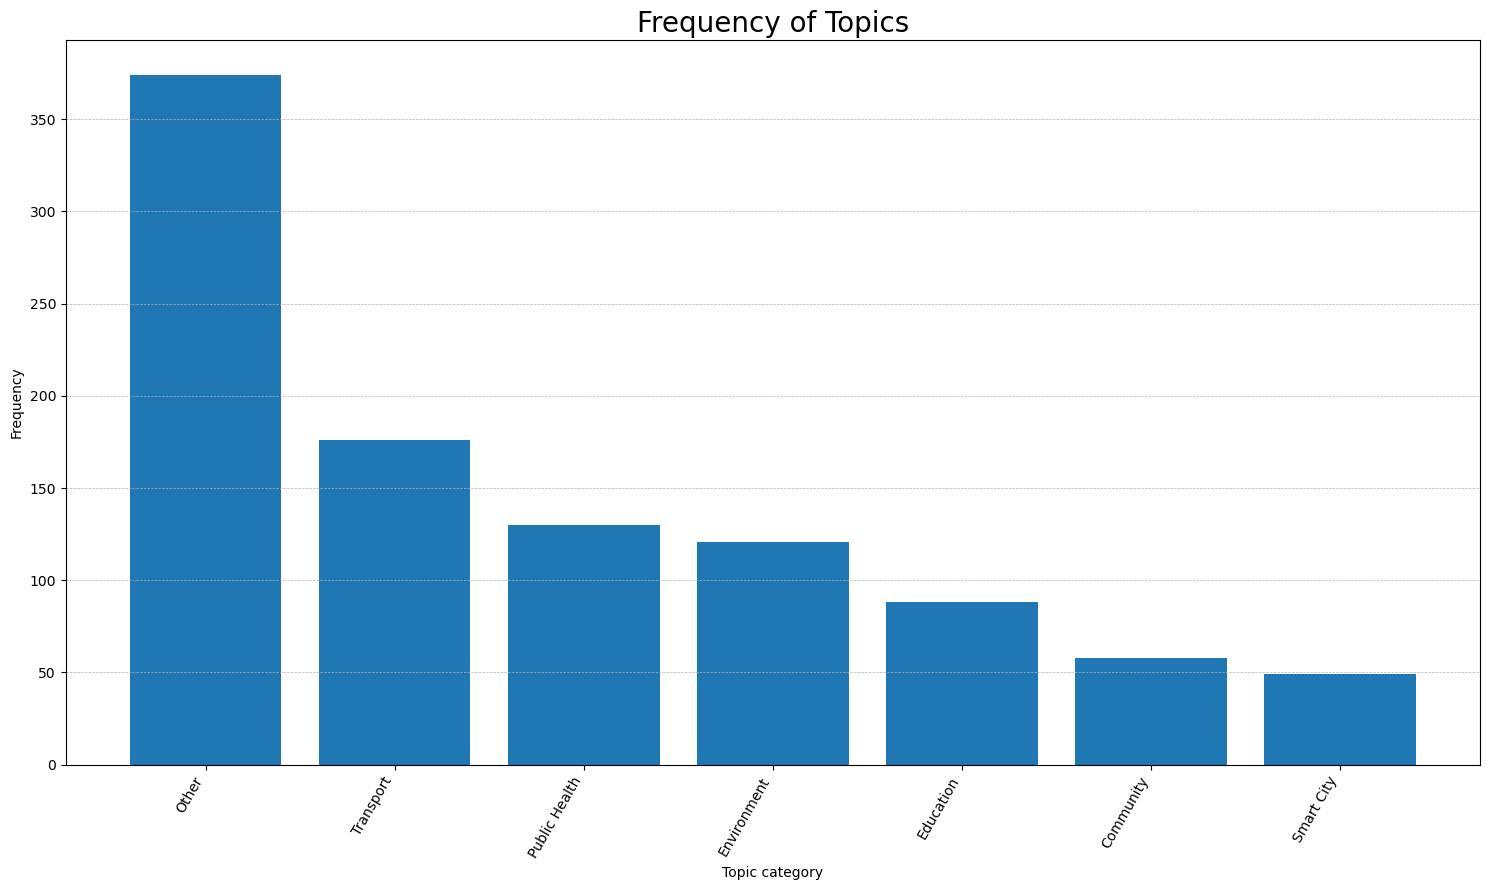

In [30]:
# -----------------------------------------------------------------------------
# Plot frequency of topic legend categories
# -----------------------------------------------------------------------------
from collections import Counter
import matplotlib.pyplot as plt

# -----------------------------------------------------------------------------
# Function to compute value–frequency distribution for a Series
# -----------------------------------------------------------------------------
def get_distribution(series):
    """
    Return two tuples: (values, frequencies), sorted by descending frequency.
    """
    counts = Counter(series.dropna().to_list())
    values, frequencies = zip(*counts.most_common())
    return values, frequencies


# Prepare data
values, frequencies = get_distribution(df['A_simple'])

# -----------------------------------------------------------------------------
# Create figure and axis
# -----------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(15, 9))

# -----------------------------------------------------------------------------
# Plot data
# -----------------------------------------------------------------------------
ax.bar(range(len(values)), frequencies)

# -----------------------------------------------------------------------------
# Format axes and labels
# -----------------------------------------------------------------------------
ax.set_title('Frequency of Topics', fontsize=20)
ax.set_yscale('linear')
ax.set_xlabel('Topic category')
ax.set_ylabel('Frequency')
ax.set_xticks(range(len(values)))
ax.set_xticklabels(values, rotation=60, ha='right')

# -----------------------------------------------------------------------------
# Enhance readability with a grid
# -----------------------------------------------------------------------------
ax.yaxis.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()


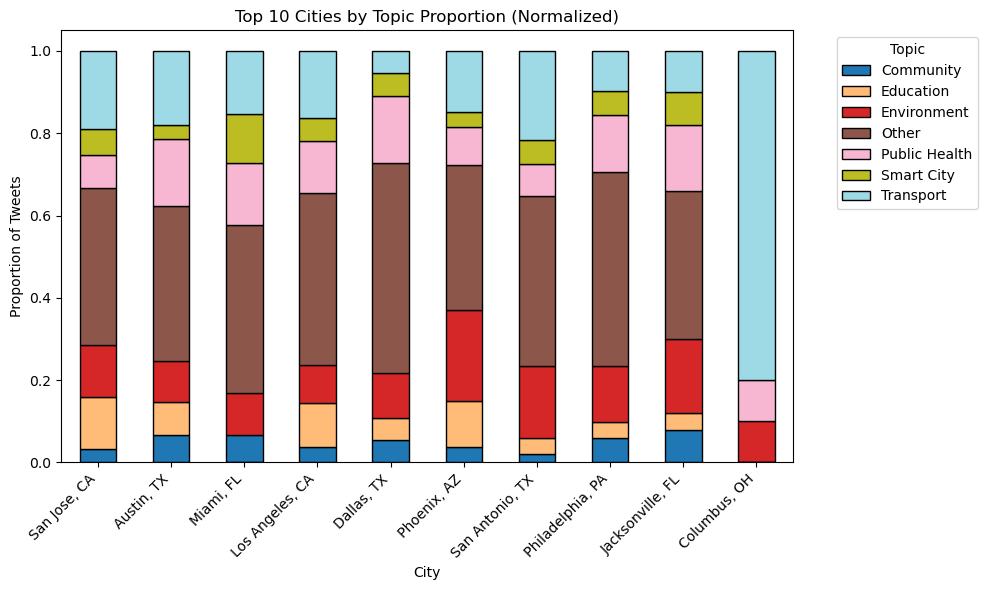

In [31]:

# --- Select Top 10 Cities by Total Tweet Count ---
top_cities = df["city"].value_counts().head(10).index
df_top = df[df["city"].isin(top_cities)]

# --- Pivot table: count tweets per topic per city ---
pivot_df = (
    df_top.pivot_table(
        index="city",
        columns="keyword_topic",
        values="tweetid",
        aggfunc="count",
        fill_value=0
    )
)

# --- Normalize each city row to sum to 1 (proportion) ---
pivot_df_norm = pivot_df.div(pivot_df.sum(axis=1), axis=0)

# --- Sort cities by total tweet volume (for order) ---
pivot_df_norm = pivot_df_norm.loc[df["city"].value_counts().head(10).index]

# --- Plot normalized stacked bar ---
pivot_df_norm.plot(
    kind="bar",
    stacked=True,
    figsize=(10, 6),
    colormap="tab20",
    edgecolor="black"
)

plt.title("Top 10 Cities by Topic Proportion (Normalized)")
plt.xlabel("City")
plt.ylabel("Proportion of Tweets")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Topic", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()

# --- Optional: Save figure ---
#plt.savefig("/mnt/data/top10_cities_topic_proportion.png", dpi=150)
plt.show()


### Heatmap of Co-occurrence

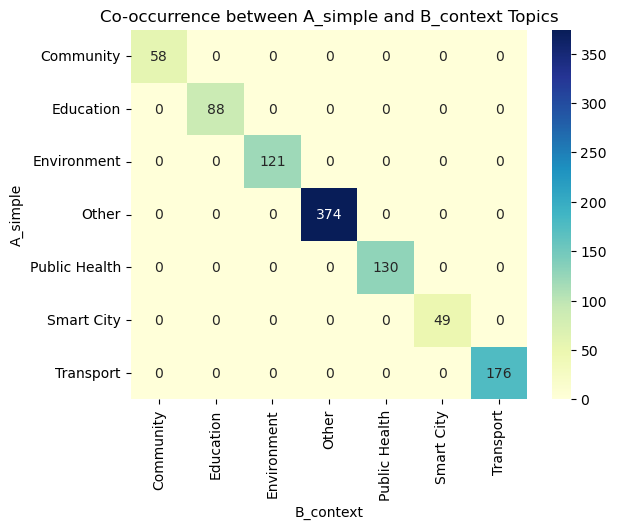

In [32]:
import seaborn as sns

cross = pd.crosstab(df["A_simple"], df["B_context"])
sns.heatmap(cross, cmap="YlGnBu", annot=True, fmt="d")
plt.title("Co-occurrence between A_simple and B_context Topics")
plt.show()

### Boxplot — tweet length by topic

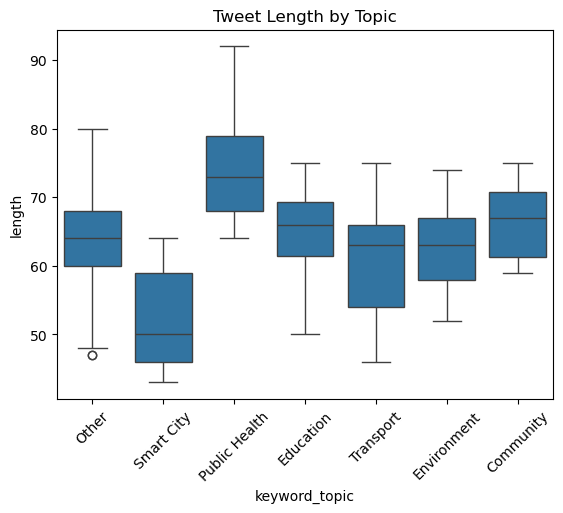

In [33]:
df["length"] = df["text"].str.len()
sns.boxplot(data=df, x="keyword_topic", y="length")
plt.title("Tweet Length by Topic")
plt.xticks(rotation=45)
plt.show()

### Confusion Matrix between Two Prompts

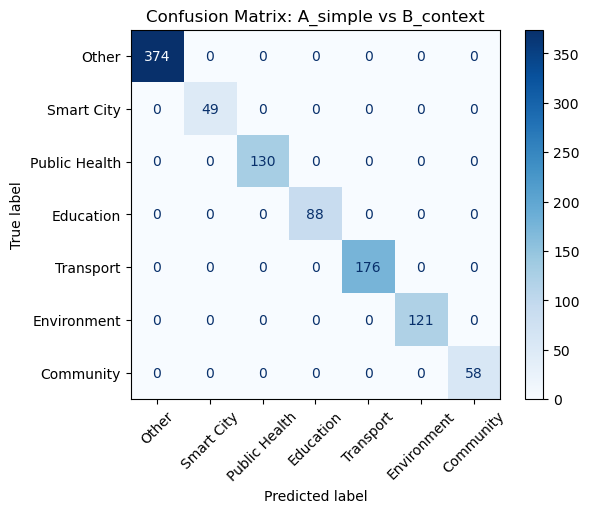

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(df["A_simple"], df["B_context"], labels=df["keyword_topic"].unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=df["keyword_topic"].unique())
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix: A_simple vs B_context")
plt.show()


### Correlation Heatmap of Classifier Agreement

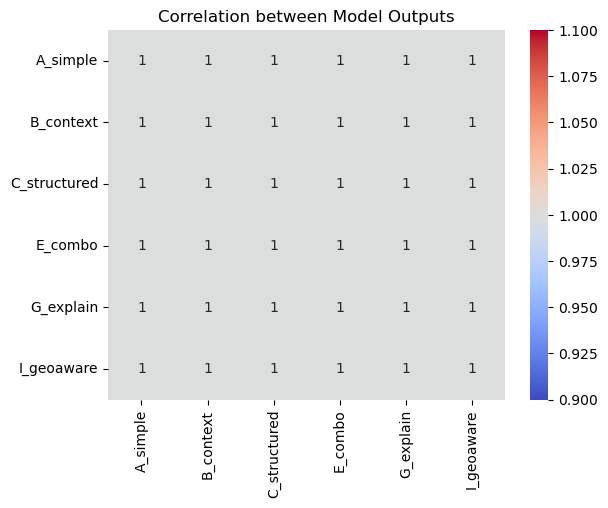

In [35]:
sns.heatmap(df[["A_simple","B_context","C_structured","E_combo","G_explain","I_geoaware"]]
            .apply(lambda x: x.astype("category").cat.codes)
            .corr(), cmap="coolwarm", annot=True)
plt.title("Correlation between Model Outputs")
plt.show()

In [36]:
# --- Check required columns ---
required_cols = {"lat", "lon"}
missing = required_cols - set(df.columns)
if missing:
    raise KeyError(f"Missing columns in CSV: {missing}")

# --- Detect topic column ---
topic_col = "keyword_topic" if "keyword_topic" in df.columns else None

# --- Create the Folium base map ---
m = folium.Map(location=[39.5, -98.35], zoom_start=4, tiles="CartoDB positron")
marker_cluster = MarkerCluster().add_to(m)

# --- Topic → Icon mapping ---
topic_icons = {
    "Public Health": "💊",
    "Environment": "🌳",
    "Transport": "🚍",
    "Education": "📚",
    "Community": "🤝",
    "Smart City": "🏙️"
}

# Default color (for fallback topics)
default_color = "blue"

# --- Add tweet markers ---
for _, row in df.iterrows():
    lat, lon = row["lat"], row["lon"]
    if pd.isna(lat) or pd.isna(lon):
        continue

    topic = row.get(topic_col, "Other") if topic_col else "Other"
    icon_emoji = topic_icons.get(topic, "📍")

    # Create popup text (city, topic, text snippet)
    popup_text = f"<b>City:</b> {row.get('city', 'N/A')}<br>"
    popup_text += f"<b>Topic:</b> {topic}<br>"
    popup_text += f"<b>Tweet:</b> {row['text'][:200]}..."

    # Custom icon (emoji label)
    icon = folium.DivIcon(html=f"<div style='font-size: 14pt'>{icon_emoji}</div>")

    folium.Marker(
        location=[lat, lon],
        popup=folium.Popup(popup_text, max_width=300),
        icon=icon
    ).add_to(marker_cluster)
m
